### Feature Extraction (After Preprocessing and Segmentation) of ECG Signals

In [2]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

### 1. Preprocessing - Denoising the signal

This function denoise uses wavelet transform to remove noise from the input signal data. It applies a symmetric 4 (sym4) wavelet and performs a multi-level discrete wavelet decomposition to break the signal into approximation and detail coefficients. The function then thresholds the detail coefficients to filter out noise based on a predefined threshold. Finally, it reconstructs the signal by applying the inverse wavelet transform, returning a cleaner version of the input data.

In [4]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


### 2. Preprocessing - Reading Raw ECG Signals for 48 contiguous ECG excerpts

| **Label** | **Description**                                                                                                                                                        |
|-----------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **N**     | Normal heartbeat or cardiac complex. The electrical activity of the heart is within the normal range, with no abnormalities or irregularities in the heart rhythm.      |
| **L**     | Left bundle branch block. An abnormality in the electrical conduction system where signals do not travel normally through the left bundle branch, affecting ventricular contractions. |
| **R**     | Right bundle branch block. An abnormality in the electrical conduction system involving the right bundle branch, similar to left bundle branch block.                     |
| **A**     | Atrial premature beat. An early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.                           |
| **V**     | Ventricular premature beat. An early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.                 |


In [5]:
path = '/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 1000
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [6]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [7]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [9]:
len(records)

48

### 3. Preprocessing - Segmentation into windows of 2000 sample points

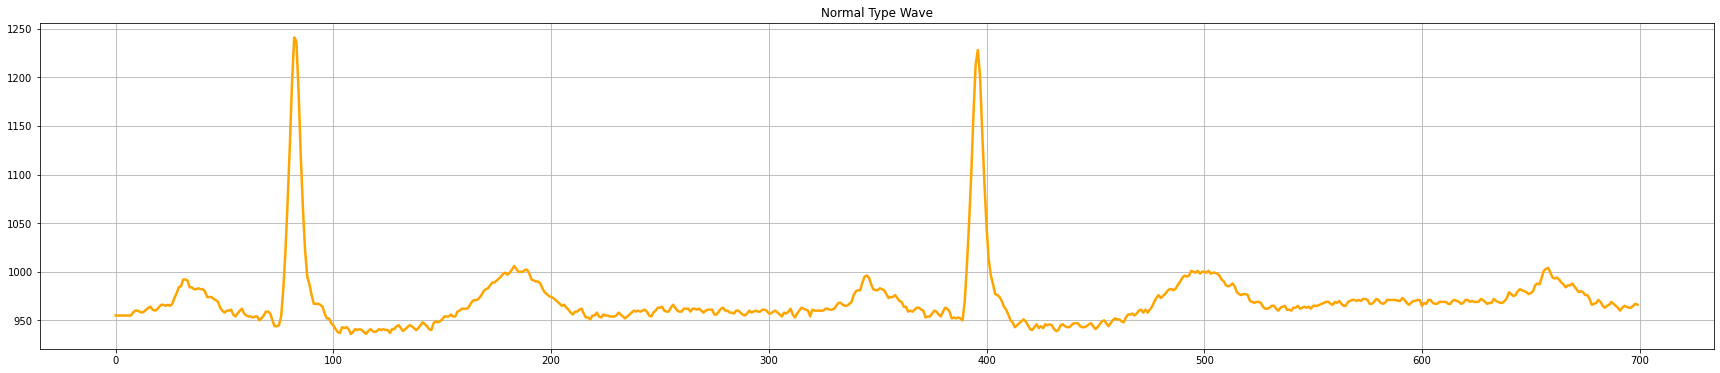

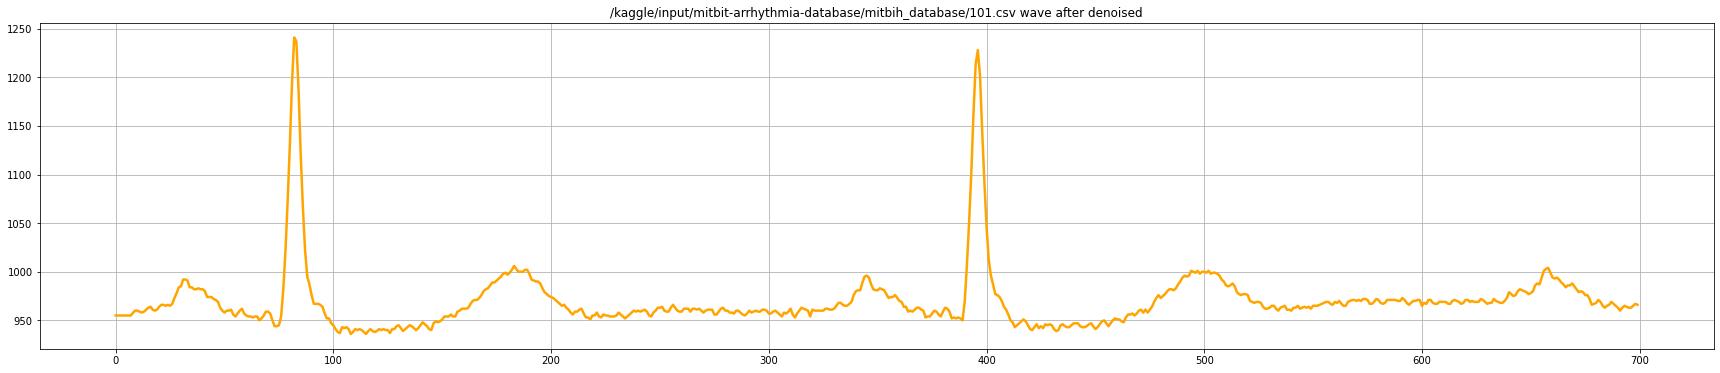

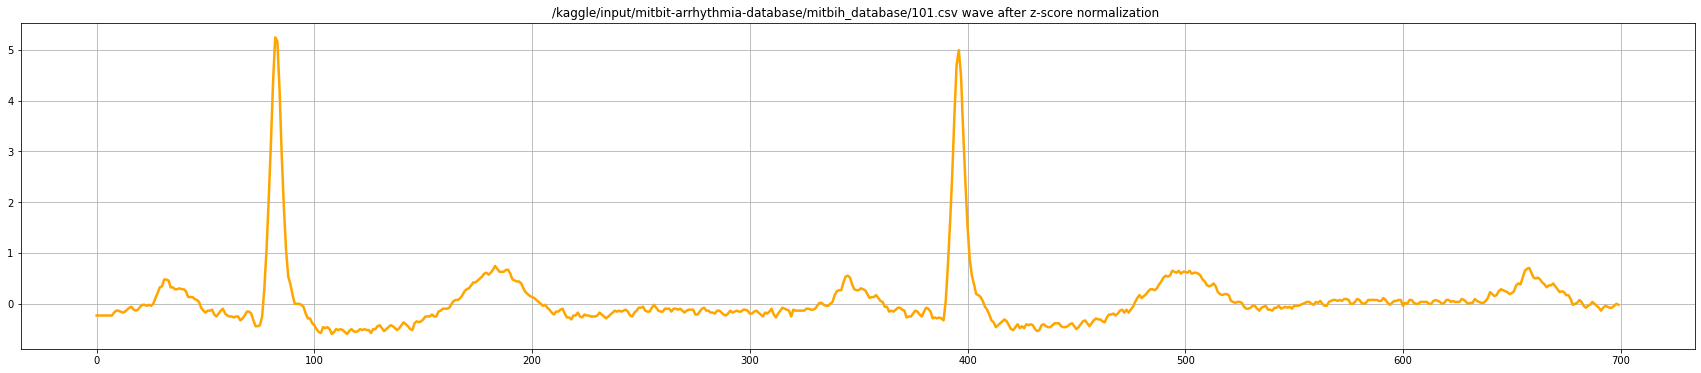

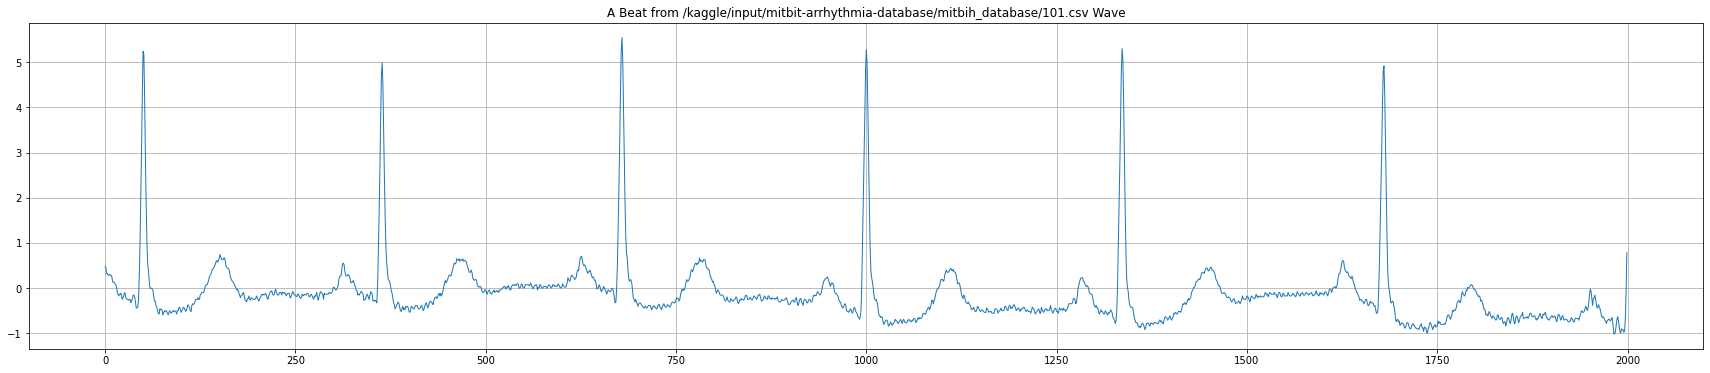

(99754, 2000) (99754,)


In [13]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title("Normal Type Wave")
        plt.plot(signals[0:700], color='orange', linewidth=2.5) 
        plt.show()
        
    
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700], color='orange', linewidth=2.5) 
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700], color='orange', linewidth=2.5) 
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [14]:
print(np.shape(X), np.shape(y))

(99754, 2000) (99754,)


In [19]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))


(99754, 2001)


### 4. Preprocessing - Balancing the classes with each class having 3000 segments

In [22]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=3000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=3000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=3000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=3000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=3000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [ ]:
data_df = X_train_df.iloc[:, :-1]  # First 2000 columns
labels_df = X_train_df.iloc[:, -1]

In [ ]:
resampled_data_df = data_df.reset_index(drop=True)

In [116]:
labels_df = labels_df.reset_index(drop=True)

### 5. Installing Neurokit Library

In [67]:
!pip install neurokit2==0.1.0

### 6. Extracting Features

In [134]:
import neurokit2 as nk

def extract_feature(X):

    features_extracted = []

    
    for i in range(0,len(X)):
        try:
            single_waveform = X.iloc[i]
            single_waveform_cleaned = nk.ecg_clean(ecg_signal = single_waveform, sampling_rate = 125, method='elgendi2010')
            _, r_peaks = nk.ecg_peaks(ecg_cleaned = single_waveform_cleaned, sampling_rate = 125)
            _, data_dwt = nk.ecg_delineate(ecg_cleaned = single_waveform_cleaned, rpeaks = r_peaks, sampling_rate = 125, show=False, method="dwt")
    
            _, data_peak = nk.ecg_delineate(ecg_cleaned = single_waveform_cleaned, rpeaks = r_peaks, sampling_rate = 125, show=False, method="peak")
            merged_obj = data_peak.copy()  # Start with all attributes from obj_1
    
            for key, value in data_dwt.items():
                if key not in merged_obj:
                    merged_obj[key] = value
            
            merged_obj['Arrhythmia_Output_class'] = labels_df[i]
            features_extracted.append(merged_obj)
        except Exception as e:
            print("Issue with", i)
        
    return features_extracted

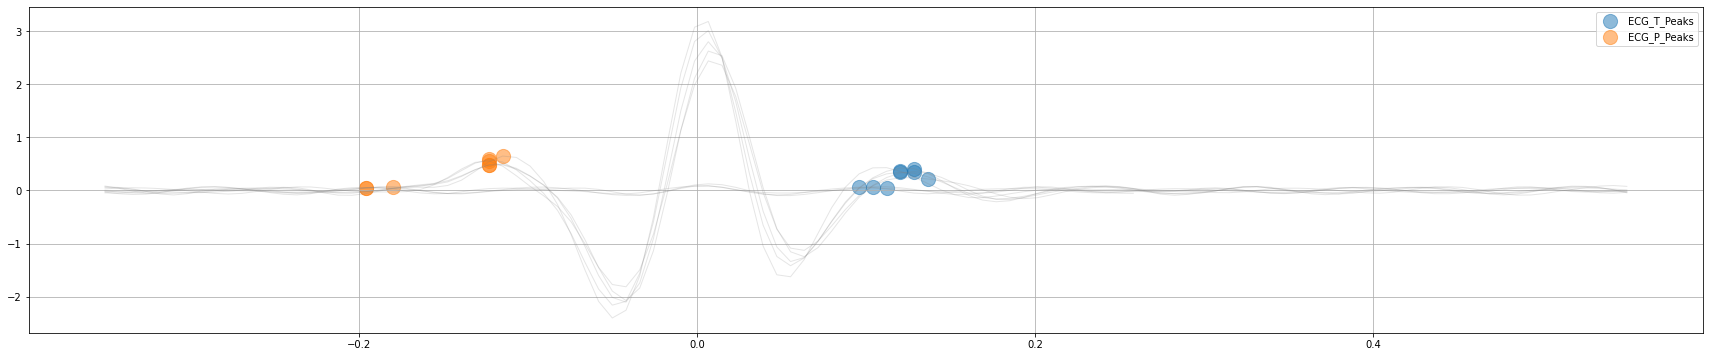

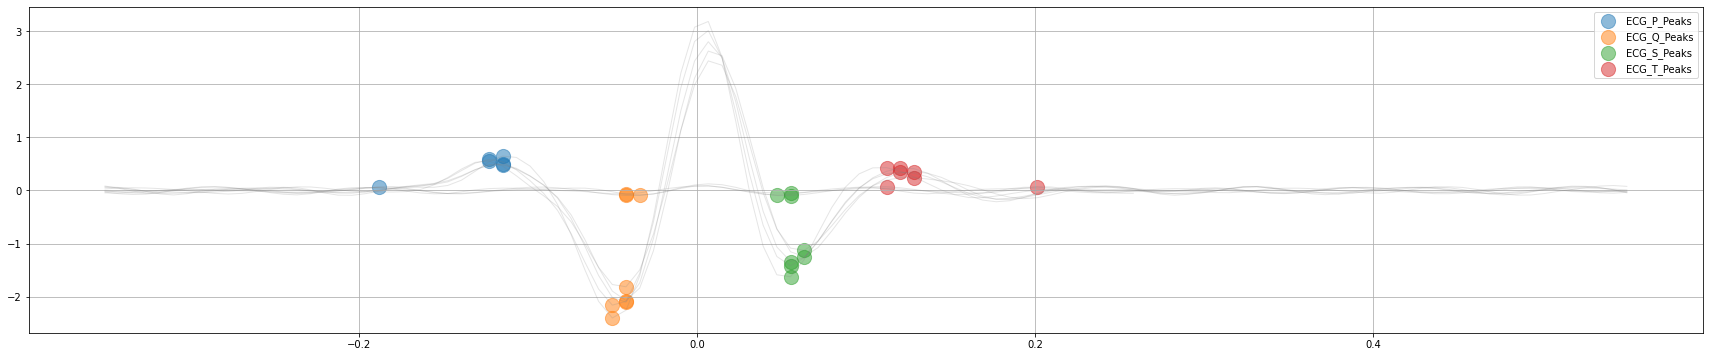

In [123]:
## Initially, I ran this on one dataframe to get the plot of the first item
X_extracted_features = extract_feature(resampled_data_df)

In [135]:
X_extracted_features = extract_feature(resampled_data_df)

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of em

Issue with 1098


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of em

Issue with 4681


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of em

Issue with 12083


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of em

Issue with 12910


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of em

### 7. Saving the extracted features into .npy file for further use

In [137]:
X_extracted_features_df = pd.DataFrame(X_extracted_features)

In [138]:
df_dict = {"data": X_extracted_features_df.values, "columns": X_extracted_features_df.columns.to_list(), "index": X_extracted_features_df.index.to_list()}
np.save('extracted_features.npy', df_dict)

print("DataFrame saved as 'complete_dataframe.npy'. Share this file.")

DataFrame saved as 'complete_dataframe.npy'. Share this file.


In [140]:
loaded_dict = np.load('extracted_features.npy', allow_pickle=True).item()

# Reconstruct the DataFrame
loaded_df = pd.DataFrame(data=loaded_dict["data"], columns=loaded_dict["columns"], index=loaded_dict["index"])

In [141]:
loaded_df.head()

,ECG_P_Peaks,ECG_Q_Peaks,ECG_S_Peaks,ECG_T_Peaks,ECG_P_Onsets,ECG_T_Offsets,ECG_T_Onsets,ECG_P_Offsets,ECG_R_Onsets,ECG_R_Offsets,Arrhythmia_Output_class
0,"[70, 280, 641, 780, 997, 1348, 1701, 1944]","[126, 289, 650, 845, 1007, 1357, 1709, 1963]","[137, 302, 662, 857, 1020, 1370, 1722, 1974]","[250, 310, 670, 864, 1028, 1378, 1729, 1992]","[53, 273, 635, 775, 992, 1342, 1696, 1928]","[256, 318, 679, 870, 1037, 1386, 1737, 1992]","[138, 303, 663, 858, 1021, 1371, 1723, 1975]","[111, 288, 649, 832, 1006, 1357, 1709, 1949]","[118, 283, 644, 840, 1000, 1351, 1704, 1960]","[142, 307, 668, 862, 1025, 1376, 1727, 1980]",0
1,"[276, 420, 527, 637, 829, 994, 1303, 1562, 182...","[286, 446, 538, 657, 867, 1006, 1315, 1574, 18...","[303, 454, 555, 670, 874, 1019, 1330, 1588, 18...","[312, 527, 564, 674, 907, 1027, 1338, 1596, 18...","[271, 416, 522, 615, 823, 990, 1299, 1558, 182...","[316, 540, 570, 682, 926, 1034, 1344, 1646, 18...","[304, 466, 556, 671, 886, 1020, 1331, 1589, 18...","[285, 428, 532, 640, 849, 1005, 1308, 1574, 18...","[276, 444, 533, 655, 864, 995, 1310, 1568, 182...","[307, 456, 562, 673, 877, 1026, 1337, 1593, 18...",0
2,"[47, 375, 672, 982, 1119, 1238, 1356, 1521, 15...","[53, 380, 678, 987, 1124, 1243, 1362, 1529, 15...","[66, 397, 692, 1002, 1144, 1261, 1376, 1537, 1...","[79, 406, 703, 1011, 1148, 1266, 1385, 1592, 1...","[-3, 342, 669, 961, 1115, 1205, 1353, 1518, 15...","[86, 414, 710, 1019, 1155, 1280, 1393, 1601, 1...","[74, 397, 692, 1003, 1145, 1270, 1377, 1573, 1...","[51, 379, 660, 986, 1124, 1230, 1344, 1512, 15...","[47, 376, 672, 982, 1131, 1239, 1357, 1528, 15...","[71, 402, 696, 1008, 1148, 1265, 1383, 1540, 1...",0
3,"[6, 135, 386, 689, 995, 1226, 1517, 1741]","[72, 143, 395, 698, 1004, 1235, 1526, 1750]","[82, 159, 411, 714, 1019, 1250, 1542, 1765]","[152, 165, 418, 722, 1026, 1256, 1549, 1772]","[-3, 130, 381, 684, 989, 1221, 1512, 1736]","[160, 174, 469, 731, 1034, 1265, 1558, 1780]","[83, 159, 412, 715, 1021, 1251, 1543, 1766]","[57, 142, 393, 697, 1003, 1234, 1525, 1750]","[64, 136, 397, 691, 997, 1228, 1519, 1743]","[86, 163, 416, 719, 1025, 1255, 1547, 1770]",0
4,"[102, 335, 559, 771, 886, 998, 1233, 1341, 146...","[108, 342, 566, 779, 924, 1005, 1242, 1348, 14...","[121, 354, 579, 792, 930, 1018, 1254, 1356, 14...","[129, 363, 586, 800, 998, 1026, 1262, 1408, 14...","[96, 329, 553, 766, 882, 992, 1200, 1338, 1453...","[136, 368, 593, 805, 998, 1033, 1268, 1413, 14...","[121, 355, 580, 793, 943, 1019, 1255, 1357, 14...","[107, 341, 565, 778, 901, 985, 1241, 1331, 146...","[103, 337, 560, 774, 921, 1000, 1237, 1342, 14...","[127, 361, 584, 797, 933, 1024, 1260, 1359, 14...",0
